# Summary of events from openFDA
#### Reactions Analysis:
* Most Reported - Diarrhoea (25.2 %)
* Anaphylactic reactions
     - greatest outcome "Patients Visited E.R." (369)
     - products from "Vit/Min/Prot/Unconv Diet(Human/Animal)" industry gave the most reaction (459)
* Ovarian Cancer - median age 55 years, greatest outcome: "Medically Important" from the "Cosmetics" industry

#### Jan 1,2004 - Jan 1, 2021 events Analysis(API limit is 1000 events):
* Top industry-reaction count -    "Vit/Min/Prot/Unconv Diet(Human/Animal) -Dyspnoea"	with 148 events reported
* Median age - 48 years

#### Outcome Analysis:
* There is only one report with outcome as 'Death' from "Cosmetics" Industry



In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import seaborn as sns

In [50]:
def get_eventdata_fromAPI(eventDataJSON):

    #Empty list to append the food event report details
    report_number_list =[]
    outcomes_list = []
    date_created_list = []
    date_started_list = []
    consumer_age_list = []
    consumer_age_unit_list = []
    consumer_gender_list = []

    event_report_reaction =[]
    event_report_product =[]
    event_report_outcome =[]


    #results key from the JSON data of the request contains the information about the food event.
    if(('results' in eventDataJSON) and (bool(eventDataJSON['results']) == True)):
        for foodevent_record in eventDataJSON['results']:

            report_number_list.append(foodevent_record['report_number'])
            date_started_list.append(foodevent_record['date_started'])
            date_created_list.append(foodevent_record['date_created'])

            #If consumer details are available in the event report. 
            if(bool(foodevent_record['consumer']) == True):

                #Some reports, doesn't have consumer age data, hence checking if 'age' key exists
                if('age' in foodevent_record['consumer']):
                    consumer_age_list.append(foodevent_record['consumer']['age'])
                else:
                    consumer_age_list.append("")

                #Some reports, doesn't have consumer age unit data, hence checking if 'age_unit' key exists
                if('age_unit' in foodevent_record['consumer']):
                    consumer_age_unit_list.append(foodevent_record['consumer']['age_unit'])
                else:
                    consumer_age_unit_list.append("")

                #Some reports, doesn't have gender data, hence checking if 'gender' key exists
                if('gender' in foodevent_record['consumer']):
                    consumer_gender_list.append(foodevent_record['consumer']['gender'])
                else:
                    consumer_gender_list.append("")
            else:
                #If consumer details are not available append empty values
                consumer_age_list.append("")
                consumer_age_unit_list.append("")
                consumer_gender_list.append("")

            #Outcomes for the food event. There can be more than 1 outcome 
            for outcome in foodevent_record['outcomes']:
                event_report_outcome.append({'report_number':foodevent_record['report_number'],"outcome" : outcome})


            #reactions for the food event. There can be more than 1 reaction
            for reaction in foodevent_record['reactions']:
                event_report_reaction.append({'report_number':foodevent_record['report_number'],"reaction" : reaction.title()})


            #Product records for the event report. There can be more than 1 product/industry associated with it
            for product_record in foodevent_record['products']:
                event_report_product.append({"report_number":foodevent_record['report_number'],
                                             "role": product_record['role'].title(),
                                             "name_brand":product_record['name_brand'].title(),
                                             "industry_code":product_record['industry_code'],
                                             "industry_name":product_record['industry_name']})


    #Create dictionary with column names and values for food event report 
    food_event_report_dict = {"report_number":report_number_list,
                                "date_created":date_created_list,
                                "date_started":date_started_list,
                                "consumer_age":consumer_age_list,
                                "consumer_age_unit":consumer_age_unit_list,
                                "consumer_gender":consumer_gender_list
                            }

     
    df_dict = {"report_df":pd.DataFrame(food_event_report_dict),
               "reaction_df":pd.DataFrame(event_report_reaction),
               "outcome_df":pd.DataFrame(event_report_outcome),
               "product_df":pd.DataFrame(event_report_product)}
    
    return df_dict


## Ovarian Cancer events analysis

In [51]:
ov_cancer_url = "https://api.fda.gov/food/event.json?search=reactions:'ovarian+cancer'&limit=1000"
ov_cancer_event_data = requests.get(ov_cancer_url).json()

ov_cancer_dfDict = get_eventdata_fromAPI(ov_cancer_event_data)

In [52]:
#Display first 5 records of dataframes
display(ov_cancer_dfDict["report_df"].head())
display(ov_cancer_dfDict["outcome_df"].head())
display(ov_cancer_dfDict["product_df"].head())


,report_number,date_created,date_started,consumer_age,consumer_age_unit,consumer_gender
0,202218,20161003,None,,,
1,2018-CFS-003029,20180223,20110101,,,
2,2019-CFS-008409,20190816,20100701,52,year(s),F
3,204715,20161202,None,,,
4,214832,20170706,20111101,,,


,report_number,outcome
0,202218,Patient Visited Healthcare Provider
1,202218,Medically Important
2,2018-CFS-003029,Medically Important
3,2019-CFS-008409,Medically Important
4,204715,Patient Visited Healthcare Provider


,report_number,role,name_brand,industry_code,industry_name
0,202218,Suspect,Exemption 4,53,Cosmetics
1,2018-CFS-003029,Suspect,Exemption 4,53,Cosmetics
2,2019-CFS-008409,Suspect,Exemption 4,53,Cosmetics
3,204715,Suspect,Exemption 4,53,Cosmetics
4,214832,Suspect,Exemption 4,53,Cosmetics


In [53]:
food_event_report_df = ov_cancer_dfDict["report_df"]

#Convert the string date_created and date_started to datetime format
food_event_report_df["date_created"] = pd.to_datetime(food_event_report_df["date_created"])
food_event_report_df["date_started"] = pd.to_datetime(food_event_report_df["date_started"])

#Get only the year part of created  date
food_event_report_df['year_created'] = food_event_report_df['date_created'].dt.year

#convert consumer_age from string to numeric
food_event_report_df["consumer_age"]= pd.to_numeric(food_event_report_df["consumer_age"])

In [54]:
#Get the dataframe ready for plot - "Display of Events by Outcomes for Ovarian Cancer Reaction"
#merge year df with outcomes df 
inner_merge_reportno_df = pd.merge(food_event_report_df,ov_cancer_dfDict["outcome_df"], on="report_number",how='left')


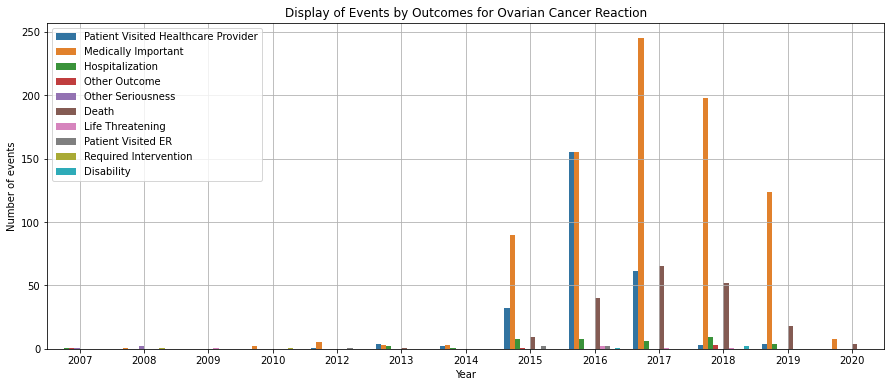

In [55]:
#plot - Display of Events by Outcomes for Ovarian Cancer Reaction
fig,ax = plt.subplots()
fig.set_size_inches([15,6])
ax = sns.countplot(x =inner_merge_reportno_df.year_created,data = inner_merge_reportno_df,
                   ax=ax,hue=inner_merge_reportno_df.outcome)
ax.set_title("Display of Events by Outcomes for Ovarian Cancer Reaction")
ax.set_ylabel("Number of events")
ax.set_xlabel("Year")
ax.legend(loc='upper left')
ax.grid(True)
plt.savefig('OverianCancer_events_display.png',bbox_inches = 'tight')

In [56]:
#Ovarian cancer by age plot. What products caused this reaction?
# industry_name entries are blank in some reports. Replace it with text "Data Unavailable"
ov_cancer_dfDict["product_df"].loc[ov_cancer_dfDict["product_df"].industry_name == "",'industry_name'] = "Data Unavailable"

#merge with product df with 
merged_reportno_df = pd.merge(food_event_report_df,ov_cancer_dfDict["product_df"], on="report_number",how='left')

#Get only reports where age is reported in year(s)
merged_reportno_df = merged_reportno_df[(merged_reportno_df["consumer_age_unit"]=="year(s)")]


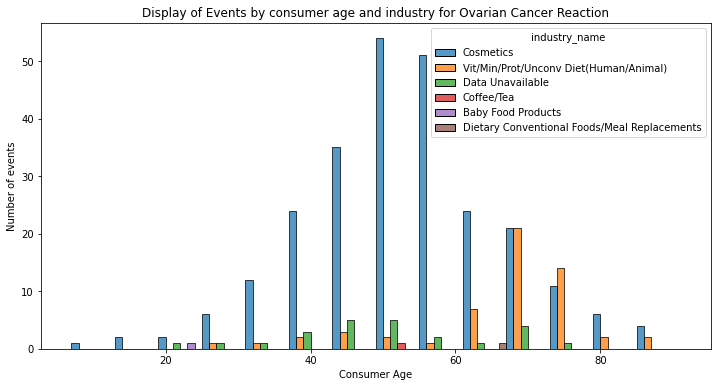

In [57]:
fig,ax = plt.subplots()
fig.set_size_inches([12,6])
ax= sns.histplot(x='consumer_age',data=merged_reportno_df,
                 hue='industry_name',multiple="dodge",ax=ax)
ax.set_title("Display of Events by consumer age and industry for Ovarian Cancer Reaction")
ax.set_ylabel("Number of events")
ax.set_xlabel("Consumer Age")
plt.savefig('OverianCancer_age_display.png',bbox_inches = 'tight')

In [58]:
print("Mean age for Ovarian Cancer:",merged_reportno_df["consumer_age"].mean())
print("Median age for Ovarian Cancer:",merged_reportno_df["consumer_age"].median())
print("Variance: ",np.var(merged_reportno_df["consumer_age"],ddof=1))
print("Standard Deviation:", np.std(merged_reportno_df["consumer_age"],ddof=1))

Mean age for Ovarian Cancer: 55.788690476190474
Median age for Ovarian Cancer: 55.0
Variance:  210.19700604122252
Standard Deviation: 14.498172506947988


In [59]:
def get_eventCountData_fromAPI(eventCountDataJSON):
    reaction_count_list = []
    #results key from the JSON data of the request contains the information about the food event.
    if(('results' in eventCountDataJSON) and (bool(eventCountDataJSON['results']) == True)):
        for cnt_record in eventCountDataJSON['results']:
            reaction_count_list.append({"term": cnt_record["term"].title(),"count":cnt_record["count"]})

    reaction_count_df = pd.DataFrame(reaction_count_list)
    
    return reaction_count_df


## Top 5 reactions

In [60]:
# Get the data for reactions count
reaction_count_url = "https://api.fda.gov/food/event.json?count=reactions.exact"
reaction_count_data = requests.get(reaction_count_url).json()

reaction_count_df = get_eventCountData_fromAPI(reaction_count_data)


In [61]:
reaction_count_df.rename(columns = {'term':'reaction'}, inplace = True)
display(reaction_count_df.head())

,reaction,count
0,Diarrhoea,13933
1,Vomiting,11830
2,Ovarian Cancer,11719
3,Nausea,10012
4,Abdominal Pain,7845


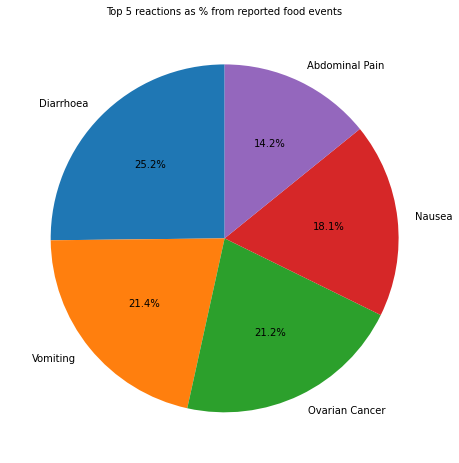

In [62]:
#plot pie chart to display top 5 reactions
fig,ax = plt.subplots()
fig.set_size_inches([8,8])

reaction_count_df.head().plot(kind='pie',y="count",ax=ax,
                        startangle=90,shadow=False,labels=reaction_count_df.reaction,
                        autopct='%1.1f%%',legend=False,fontsize=10)

ax.set_ylabel("")
ax.set_title("Top 5 reactions as % from reported food events",fontsize=10)
plt.savefig('Top5_reactions.png')
plt.show()


## Jan 1,2004 - Jan 1, 2021 events Analysis(API limit is 1000 events)

In [63]:
#Get another 1000 records for a date range as below
#Get FDA food event data between Jan 01, 2004 and Jan 1, 2021. 
daterange_food_url = "https://api.fda.gov/food/event.json?search=date_started:[20040101+TO+20210101]&limit=1000"
daterange_food_event_data = requests.get(daterange_food_url).json()

daterange_dfDict = get_eventdata_fromAPI(daterange_food_event_data)


In [64]:
merged_df = pd.merge(daterange_dfDict["report_df"],daterange_dfDict["reaction_df"],on="report_number")
merged_df = pd.merge(merged_df,daterange_dfDict["outcome_df"],on="report_number",how='left')
merged_df = pd.merge(merged_df,daterange_dfDict["product_df"],on="report_number",how='left')
#merged_df.head()


#### Industry-Reaction count

In [65]:
merged_df["consumer_age"] = pd.to_numeric(merged_df["consumer_age"])
plot_df = pd.DataFrame(merged_df.groupby(["industry_name","reaction"])["report_number"].agg("count").sort_values(ascending=False))
plot_df.columns = ["Count"]
display(plot_df.head(10))

Count
industry_name                          reaction             
Vit/Min/Prot/Unconv Diet(Human/Animal) Dyspnoea          148
                                       Nausea            147
                                       Headache          118
                                       Dizziness         110
Cosmetics                              Ovarian Cancer    105
Vit/Min/Prot/Unconv Diet(Human/Animal) Vomiting           95
Cosmetics                              Alopecia           82
Vit/Min/Prot/Unconv Diet(Human/Animal) Malaise            82
                                       Fatigue            81
                                       Diarrhoea          77

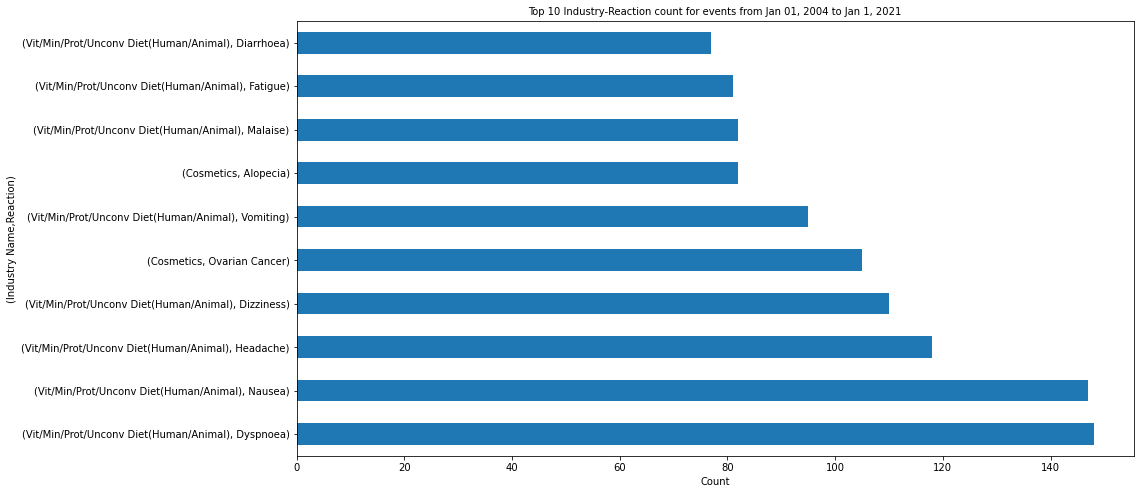

In [66]:
# Plot industry report counts from Jan 01, 2004 and Jan 1, 2021
fig,ax = plt.subplots()
fig.set_size_inches([15,8])
merged_df.groupby(['industry_name','reaction']).count()['report_number'].sort_values(ascending=False).head(10).plot.barh(ax=ax)
ax.set_xlabel("Count")
ax.set_ylabel("(Industry Name,Reaction)")
ax.set_title("Top 10 Industry-Reaction count for events from Jan 01, 2004 to Jan 1, 2021",fontsize=10)
#ax.tick_params(axis='x', rotation=90)
plt.savefig('IndustryReaction_count.png',bbox_inches = 'tight')

#### Consumer Age- gender count, mean and median

Mean consumer age: 46.65351972041937 yrs
Median consumer age: 48.0 yrs
Standard Deviation: 20.36941875416365
                        var        std
consumer_gender                       
F                325.097376  18.030457
M                554.988903  23.558202
Not Reported     720.576537  26.843557


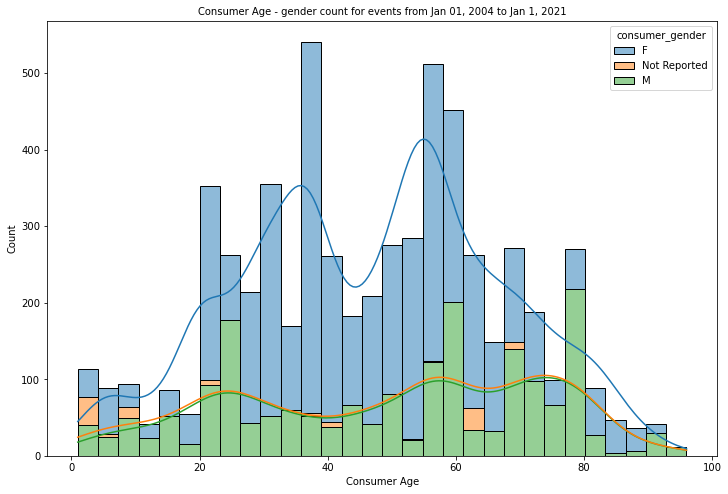

In [67]:
merged_df.loc[merged_df.consumer_gender == "",'consumer_gender'] = "Not Reported"


fig,ax = plt.subplots()
fig.set_size_inches([12,8])
ax= sns.histplot(x="consumer_age",data=merged_df,ax=ax,hue="consumer_gender",multiple="stack",kde=True)

ax.set_xlabel("Consumer Age")
ax.set_ylabel("Count")
ax.set_title("Consumer Age - gender count for events from Jan 01, 2004 to Jan 1, 2021",fontsize=10)
plt.savefig('Age_gender_count.png',bbox_inches = 'tight')

print("Mean consumer age:", merged_df["consumer_age"].mean(), "yrs")
print("Median consumer age:",merged_df["consumer_age"].median(), "yrs")
print("Standard Deviation:", np.std(merged_df["consumer_age"],ddof=1))
print(merged_df.groupby("consumer_gender")['consumer_age'].agg([np.var,np.std]))


In [68]:
print(merged_df.groupby("consumer_gender")['consumer_age'].agg([np.var,np.std]))

                        var        std
consumer_gender                       
F                325.097376  18.030457
M                554.988903  23.558202
Not Reported     720.576537  26.843557


## Outcome Analysis

In [69]:

death_outcome_url = "https://api.fda.gov/food/event.json?search=outcomes:'death'"
death_outcome_data = requests.get(death_outcome_url).json()

death_outcome_dfDict = get_eventdata_fromAPI(death_outcome_data)


In [70]:
death_merged_df = pd.merge(death_outcome_dfDict["report_df"],death_outcome_dfDict["product_df"],on="report_number",how='left')
display(death_merged_df.head())

#What was the reaction for that death event report?
display(death_outcome_dfDict["reaction_df"])

,report_number,date_created,date_started,consumer_age,consumer_age_unit,consumer_gender,role,name_brand,industry_code,industry_name
0,2018-CFS-015017,20181226,20140310,81,year(s),F,Suspect,Exemption 4,53,Cosmetics


,report_number,reaction
0,2018-CFS-015017,Injury
1,2018-CFS-015017,Death


## Anaphylactic reaction - outcome count

In [71]:
#Get outcome count for anaphylactic_reaction
anaphylactic_reaction_url = "https://api.fda.gov/food/event.json?search=reaction:'anaphylactic+reaction'&count=outcomes.exact"

anaphylactic_reaction_data = requests.get(anaphylactic_reaction_url).json()

anaphylactic_reaction_count_df = get_eventCountData_fromAPI(anaphylactic_reaction_data)


,outcome,count
0,Patient Visited Er,369
1,Medically Important,318
2,Life Threatening,286
3,Hospitalization,205
4,Patient Visited Healthcare Provider,194
5,Other Outcome,122
6,Required Intervention,97
7,Other Seriousness,64
8,Disability,36
9,Death,4


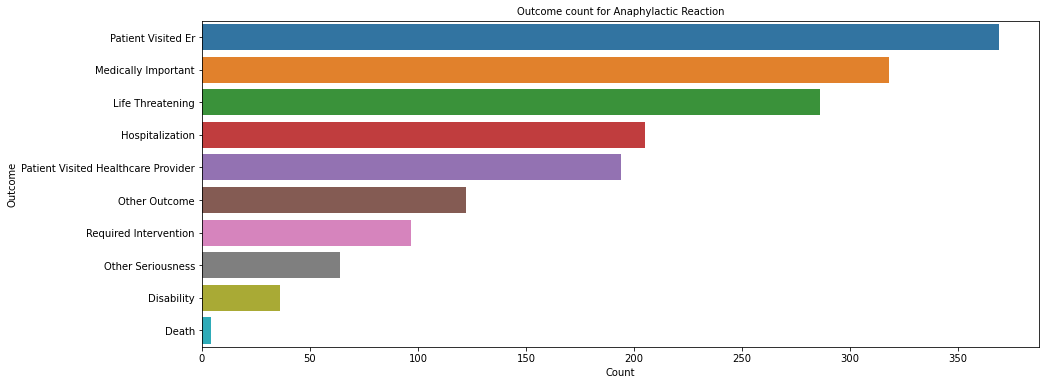

In [72]:

anaphylactic_reaction_count_df.rename(columns = {'term':'outcome'}, inplace = True)
display(anaphylactic_reaction_count_df)
#PLOT anaphylactic_reaction_data and its outcome count
fig,ax = plt.subplots()
fig.set_size_inches([15,6])
ax = sns.barplot(x="count",y="outcome",ax=ax,data=anaphylactic_reaction_count_df)
ax.set_xlabel("Count")
ax.set_ylabel("Outcome")
ax.set_title("Outcome count for Anaphylactic Reaction",fontsize=10)
plt.savefig('anaphylactic_reaction_outcome_count.png',bbox_inches = 'tight')

### Anaphylactic reaction industry count

In [73]:
#Get outcome count for anaphylactic_reaction
anaphylactic_reaction_industryurl = "https://api.fda.gov/food/event.json?search=reaction:'anaphylactic+reaction'&count=products.industry_name.exact"

anaphylactic_reaction_industrydata = requests.get(anaphylactic_reaction_industryurl).json()

anaphylactic_reaction_industrycount_df = get_eventCountData_fromAPI(anaphylactic_reaction_industrydata)

,industry,count
0,Vit/Min/Prot/Unconv Diet(Human/Animal),459
1,Cosmetics,189
2,Bakery Prod/Dough/Mix/Icing,66
3,Cereal Prep/Breakfast Food,28
4,Dietary Conventional Foods/Meal Replacements,26
5,Choc/Cocoa Prod,25
6,Vegetables/Vegetable Products,20
7,Ice Cream Prod,19
8,Candy W/O Choc/Special/Chew Gum,18
9,Soft Drink/Water,17


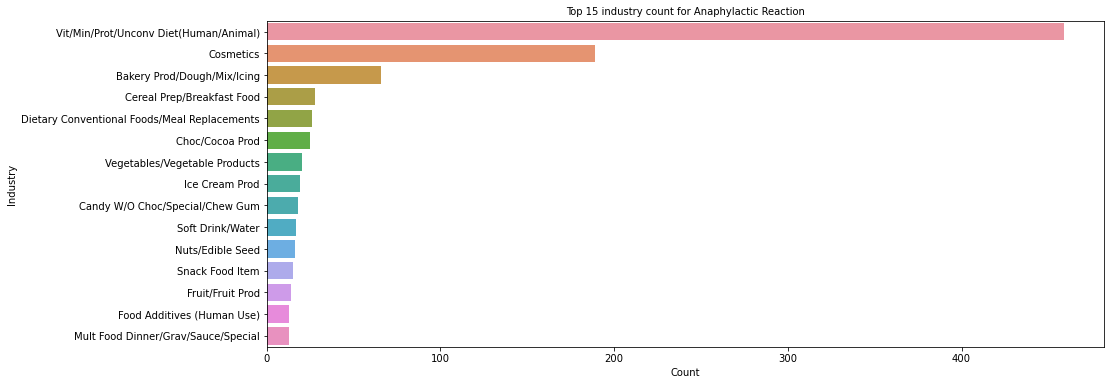

In [74]:

anaphylactic_reaction_industrycount_df.rename(columns = {'term':'industry'}, inplace = True)
anaphylactic_reaction_industrycount_df = anaphylactic_reaction_industrycount_df.sort_values(by='count',ascending=False).head(15)
display(anaphylactic_reaction_industrycount_df)
#PLOT anaphylactic_reaction_data and its outcome count
fig,ax = plt.subplots()
fig.set_size_inches([15,6])
ax = sns.barplot(x="count",y="industry",ax=ax,data=anaphylactic_reaction_industrycount_df)
ax.set_xlabel("Count")
ax.set_ylabel("Industry")
ax.set_title("Top 15 industry count for Anaphylactic Reaction",fontsize=10)
plt.savefig('anaphylactic_reaction_industry_count.png',bbox_inches = 'tight')